In [1]:
import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, MaxPooling2D, Conv2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence

2023-10-18 16:01:09.790788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:01:10.323086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-18 16:01:11.151278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 16:01:11.171148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 16:01:11.171334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
import sys, os
import numpy as np
import h5py
import math
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import tensorflow.keras.layers as nn

from tqdm import tqdm
from PIL import Image
from tensorflow import keras, einsum
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, Input, MaxPooling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow_probability.python.distributions import kl_divergence
from einops import rearrange
from einops.layers.tensorflow import Rearrange
from DataMaker import *

/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
channels = 5
BATCH_SIZE = 32

TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing.hdf5'

gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
print(train_gen[0][0].shape) # a batch of images
print(train_gen[0][1].shape) # a batch of corresponding redshifts

(32, 5, 64, 64)
(32,)


In [9]:
batch_count = 0
def next_batch():
    global batch_count
    train_set = train_gen[batch_count]
    x_train = np.asarray(np.transpose(train_set[0], (0, 2, 3, 1)))
    y_train = train_set[1]
    batch_count = batch_count + 1
    if batch_count == len(train_gen) - 1:
        batch_count = 0
    return x_train, y_train

In [6]:
n = 10000
t = 2000
v = 2000

In [7]:
hf_train = h5py.File('/data/HSC/HSC_v6/step3A/64x64_training_z_less_than_2_small.hdf5', 'r')
# hf_test = h5py.File('/data/HSC/HSC_v6/step3A/64x64_testing_z_less_than_2_small.hdf5', 'r')
hf_test = h5py.File('/data3/Billy/64x64_cvae_generated_15.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step3A/64x64_validation_z_less_than_2_small.hdf5', 'r')
x_train = np.asarray(np.transpose(hf_train['image'][0 : ],(0, 2, 3, 1)))
x_test = np.asarray(np.transpose(hf_test['image'][0 : ],(0, 2, 3, 1)))
x_validation = np.asarray(np.transpose(hf_validation['image'][0 : ], (0, 2, 3, 1)))
n = 10000
t = 2000
v = 2000
max_value = 1 # 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0 : ])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0 : ])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0 : ])[..., None]
hf_train.close()
hf_test.close()
hf_validation.close()

In [10]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype = dtype, initializer = lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable = True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t[ ..., : n],
                       scale = tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims = 1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype = dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t, scale = 0.01),
            reinterpreted_batch_ndims = 1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean = 0., stddev = 0.03)
    loc = tf.Variable(
        initial_value = loc_norm(shape = (n, ), dtype = dtype)
    )
    scale_norm = tf.random_normal_initializer(mean = -3., stddev = 0.1)
    scale = tf.Variable(
        initial_value = scale_norm(shape = (n, ), dtype = dtype)
    )
    return tf.concat([loc, scale], 0)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [11]:
model_variational = Sequential([
    InputLayer(input_shape=(64, 64, 5)),
    
    # First Conv block
    tfpl.Convolution2DFlipout(16, kernel_size = (3, 3), activation = None, kernel_divergence_fn = kl_divergence_function),
    BatchNormalization(),
    Activation('relu'),
    tfpl.Convolution2DFlipout(32, kernel_size = (3, 3), activation = None, kernel_divergence_fn = kl_divergence_function),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    
    # Second Conv block
    Conv2D(64, kernel_size = (3, 3), activation = None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel_size = (3, 3), activation = None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dropout(0.3),
    
    # Dense Variational layer
    tfpl.DenseVariational(64, 
                          make_posterior_fn = posterior_mean_field,
                          make_prior_fn = prior_trainable,
                          kl_weight = 1 / n),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    
    # Output layer
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_variational.build((10000, 64, 64, 5))

model_variational.summary()

/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout (Conv2DFlipo  (None, 62, 62, 16)       1456      
 ut)                                                             
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 62, 62, 16)        0         
                                                                 
 conv2d_flipout_1 (Conv2DFli  (None, 60, 60, 32)       9248      
 pout)                                                           
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 32)       128       
 hNormalization)                                        

In [12]:
def loss_function(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model_variational.compile(optimizer = Adam(learning_rate = 0.001), loss = loss_function, metrics = [keras.metrics.RootMeanSquaredError()])

In [13]:
import tensorboard

model_name = 'bayesian_cnn_rockfish_example'

# checkpoint_filepath = os.path.join('/data/tuando/models/', model_name) + '/' + model_name

weights_path = os.path.join('/data3/Billy/models/', model_name) + '/weights'

# log_dir = os.path.join('/data/tuando/logs/', model_name)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, verbose = 1, save_freq = 150*250)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

LR_callback = ReduceLROnPlateau()

In [14]:
for i in tqdm(range(len(train_gen))):
    x_train, y_train = next_batch()
    model_variational.fit(x = x_train, y = y_train, epochs = 1, shuffle = True, verbose = 0, validation_data = (x_validation, y_validation), callbacks = [LR_callback])

  0%|          | 0/6393 [00:00<?, ?it/s]2023-10-18 16:01:23.848565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-18 16:01:24.313937: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-18 16:01:24.455078: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fdb17ed6290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-18 16:01:24.455100: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-18 16:01:24.458452: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-18 16:01:24.516140: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-18 16:01:24.564842: I ./te

KeyboardInterrupt: 

In [ ]:
model_variational.fit(x = x_train, y = y_train, epochs = 60, shuffle = True, verbose = 1, validation_data = (x_validation, y_validation), callbacks = [LR_callback])

In [ ]:
model_variational.save_weights(weights_path)

In [ ]:
model_variational.load_weights(weights_path)

In [15]:
photoz = []

for i in range(t):
    photoz.append(model_variational(np.array([x_test[i]])).mean()[0][0])

photoz = np.asarray(photoz).astype('float32')

In [16]:
specz = np.asarray(y_test)[ : , 0]

In [17]:
photoz_err = []

for i in range(t):
    photoz_err.append(model_variational(np.array([x_test[i]])).stddev()[0][0])

In [18]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([specz, photoz])).astype('float32')
z = gaussian_kde(xy)(xy)

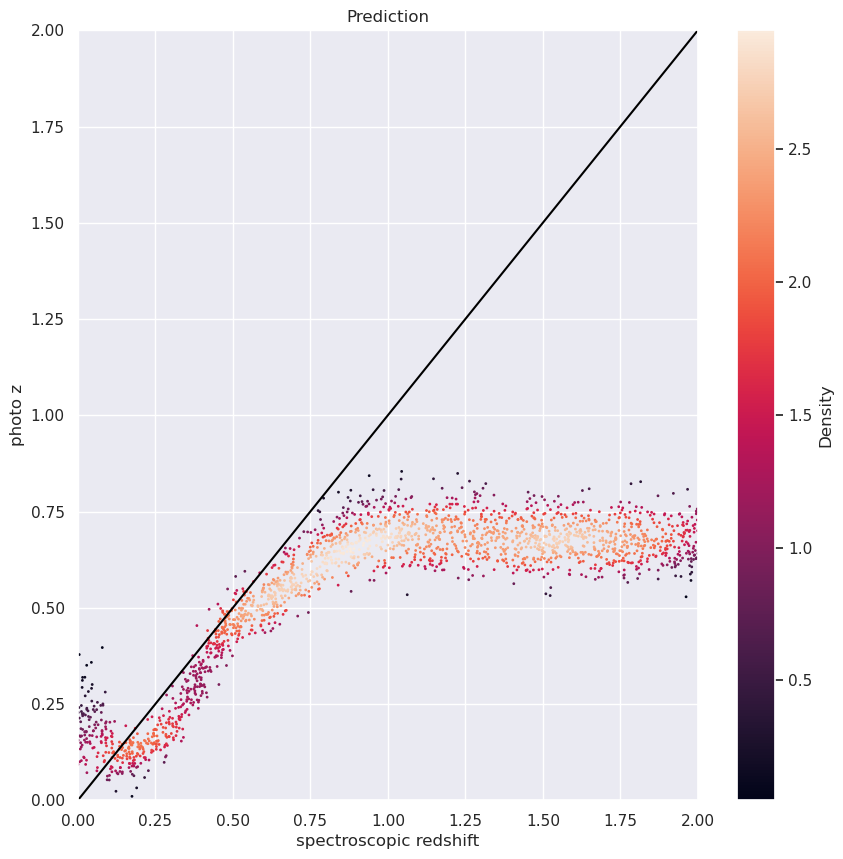

In [19]:
import seaborn as sns
z_max = 2
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz, photoz, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [20]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0, t):
    if np.abs(specz[i]-photoz[i]) <= photoz_err[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)

Coverage: 0.648


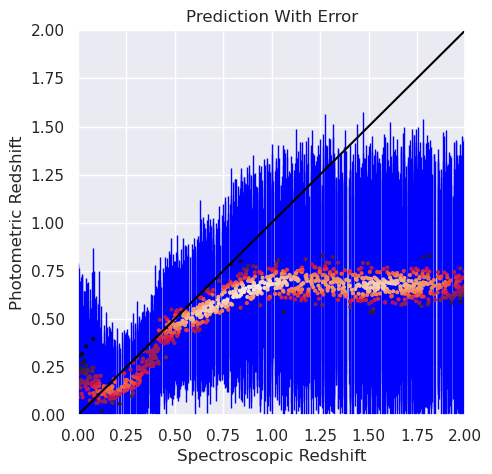

In [21]:
sns.set(rc = {'figure.figsize' : (5, 5), 'lines.markersize' : 40})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
display_size = 1000
scatter_plot = ax.scatter(specz[ : display_size], photoz[ : display_size], c = z[ : display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(specz[ : display_size], photoz[ : display_size], yerr = photoz_err[ : display_size], fmt = "o", markersize = 0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction With Error')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: " + str(overlap_variational / t))

In [ ]:
combined_array_variational = np.transpose(np.vstack((specz, photoz, photoz_err, overlap_array_variational))) 

In [ ]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x : x[0])

In [ ]:
bins_variational = int(z_max * 5)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational, bins_variational)
coverage_variational = []
for i in range(0, bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational / len(splitted_sorted_combined_array_variational[i]) / 0.6827)
x_array = np.arange(0, z_max, z_max / bins_variational)

In [ ]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.title('Coverage')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Coverage')
plt.ylim([0, 1.5])
plt.plot([0, 2], [1, 1], color = 'black', linestyle = 'dashed')
plt.annotate("Underconfident", xy = (0, 1.06), color = 'black', size = 12)
plt.annotate("Overconfident", xy = (0, 0.9), color = 'black', size = 12)
print("Coverage: "+str(overlap_variational / t))

In [ ]:
mean_array = []
for i in range(0, bins_variational):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array_variational[i])):
        bias = (splitted_sorted_combined_array_variational[i][j][1] - splitted_sorted_combined_array_variational[i][j][0]) / (1 + splitted_sorted_combined_array_variational[i][j][0])
        total += bias / (1 + splitted_sorted_combined_array_variational[i][j][0])
    mean_array.append(total / len(splitted_sorted_combined_array_variational[i]))
x_array = np.arange(0, z_max, z_max / bins_variational)

In [ ]:
error_array = []
for i in range(0, bins_variational):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        error_total += splitted_sorted_combined_array_variational[i][j][2]
    error_array.append(error_total / len(splitted_sorted_combined_array_variational[i]))

In [ ]:
sns.set(rc = {'figure.figsize' : (5, 5), 'lines.markersize' : 40})
plt.rcParams.update({'font.size' : 40})
plt.scatter(x_array, mean_array, marker = 'o', color = 'blue', s = 4)
# plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2)
plt.title('Bias Plot for Probabilistic Model')
plt.xlabel('True Redshift')
plt.ylabel('Bias: (Predicted - True) / (1 + True)')
plt.plot([0, z_max], [0, 0], color = 'black')
plt.plot([0, z_max], [0.003, 0.003], color = 'black', linestyle = 'dashed')
plt.plot([0, z_max], [-0.003, -0.003], color = 'black', linestyle = 'dashed')
plt.ylim([-0.1, 0.1])
plt.show()

In [ ]:
combined_outlier_array = np.transpose(np.vstack((specz, photoz, photoz_err)))
sorted_combined_outlier_array = sorted(combined_outlier_array, key = lambda x : x[0])
bins_outlier = int(z_max * 20)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array, bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0, bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] - splitted_sorted_combined_outlier_array[i][j][0]) >= 3 * splitted_sorted_combined_outlier_array[i][j][2]:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count / len(specz) * bins_outlier)
x_array_outlier = np.arange(0, z_max, z_max / bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0, z_max])
plt.ylim([0, 1/2])
plt.show()

In [ ]:
combined_outlier_array = np.transpose(np.vstack((specz,np.subtract(photoz, specz))))
sorted_combined_outlier_array = sorted(combined_outlier_array, key = lambda x : x[0])
bins_outlier = int(z_max * 10)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array, bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0, bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] / (splitted_sorted_combined_outlier_array[i][j][0] + 1)) >= .15:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count / len(specz) * bins_outlier)
x_array_outlier = np.arange(0, z_max, z_max /bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0, z_max])
plt.ylim([0, 1])
plt.show()

print("Outlier Rate: "+str(outlier_count_total / len(specz)))

In [ ]:
# END